In [10]:
# import packages
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

In [11]:
df = pd.read_excel('lending_clubFull_Data_Set.xlsx')
df = df.query('loan_status == "Fully Paid" or loan_status == "Charged Off"').sample(frac=1)

In [12]:
non_empty_columns = df.columns[((df.isna().sum() / len(df)) < 0.1)].values
df = df[non_empty_columns].interpolate(method='pad') # fill na withs interpolation

In [13]:
# 1 = good, 0 = default
df.loc[:, 'loan_status'] = df['loan_status'].replace({'Fully Paid': 1, 'Charged Off': 0})
# 1 = OWN, 0 = RENT
df.loc[:, 'home_ownership'] = df['home_ownership'].replace({'MORTGAGE': 1, 'OWN': 1, 'RENT': 0, 'OTHER': 0, 'NONE': 0})

COLS = ['home_ownership', 'annual_inc', 'dti', 'fico_range_low', 'loan_status']

In [14]:
df.corr()['loan_status'].drop(COLS).nlargest(n=3)

last_fico_range_high    0.693481
last_fico_range_low     0.587075
fico_range_high         0.146551
Name: loan_status, dtype: float64

In [15]:
df.corr()['loan_status'].drop(COLS).nsmallest(n=3)

int_rate               -0.246193
acc_open_past_24mths   -0.110641
num_tl_op_past_12m     -0.094784
Name: loan_status, dtype: float64

In [16]:
COLS += ['last_fico_range_high', 'int_rate']
df = df[COLS]

train = df.iloc[:7000]
validation = df.iloc[7000:10000]
test = df.iloc[10000:]

In [17]:
# remove target column to create feature only dataset
X_train = train.drop('loan_status', 1)
X_val = validation.drop('loan_status', 1)
X_test = test.drop('loan_status', 1)


# Scale data using the mean and standard deviation of the training set. 
# This is not necessary for the simple logistic regression we will do here 
# but should be done if L1 or L2 regrularization is carried out
X_test=(X_test-X_train.mean())/X_train.std()
X_val=(X_val-X_train.mean())/X_train.std()
X_train=(X_train-X_train.mean())/X_train.std()

# store target column as y-variables 
y_train = train['loan_status']
y_val=validation['loan_status']
y_test = test['loan_status']


In [18]:
freq = y_train.value_counts()           # count frequency of different classes in training swet
freq/sum(freq)*100                      # get percentage of above

1    78.9
0    21.1
Name: loan_status, dtype: float64

In [19]:
# Create an instance of logistic regression named lgstc_reg on scaled data

lgstc_reg_none =  LogisticRegression(penalty="none",solver="newton-cg")
lgstc_reg_l1 =  LogisticRegression(penalty="l1",solver="liblinear")
lgstc_reg_l2 =  LogisticRegression(penalty="l2",solver="newton-cg")

# Fit logististic regression to training set
lgstc_reg_none.fit(X_train, y_train)
lgstc_reg_l1.fit(X_train, y_train)
lgstc_reg_l2.fit(X_train, y_train)

print('None:', lgstc_reg_none.intercept_[0], lgstc_reg_none.coef_[0])
print('L1  :', lgstc_reg_l1.intercept_[0], lgstc_reg_l1.coef_[0])
print('L2  :', lgstc_reg_l2.intercept_[0], lgstc_reg_l2.coef_[0])

None: 2.5839264104173996 [-0.01754962 -0.09764627 -0.40730006 -0.30667415  2.62855598 -0.12993262]
L1  : 2.5755910150862933 [-0.0158418  -0.0947016  -0.40368983 -0.30165055  2.61976614 -0.12688042]
L2  : 2.5761894086859827 [-0.01711684 -0.09664939 -0.40503807 -0.30378793  2.61690124 -0.13028792]


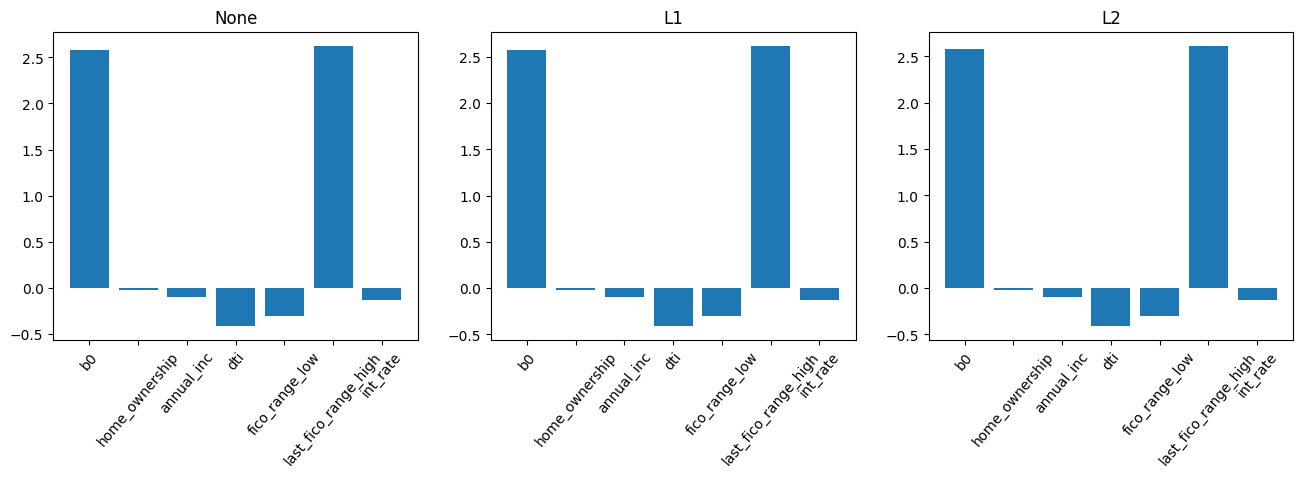

In [59]:
x_cols = ['b0'] + X_train.columns.to_list()
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,4))
ax[0].bar(x_cols, np.concatenate([lgstc_reg_none.intercept_,lgstc_reg_none.coef_[0]]))
ax[0].set_xticklabels(x_cols, rotation = 50)
ax[0].set_title('None')
ax[1].bar(x_cols, np.concatenate([lgstc_reg_l1.intercept_,lgstc_reg_l1.coef_[0]]))
ax[1].set_xticklabels(x_cols, rotation = 50)
ax[1].set_title('L1')
ax[2].bar(x_cols, np.concatenate([lgstc_reg_l2.intercept_,lgstc_reg_l2.coef_[0]]))
ax[2].set_xticklabels(x_cols, rotation = 50)
ax[2].set_title('L2');


In [56]:
# y_train_pred, y_val_pred, and y_test_pred are the predicted probabilities for the training set
# validation set and test set using the fitted logistic regression model

def print_ml(lgstc_reg):
    y_train_pred=lgstc_reg.predict_proba(X_train)
    y_val_pred=lgstc_reg.predict_proba(X_val)
    y_test_pred=lgstc_reg.predict_proba(X_test)

    # Calculate maximum likelihood for training set, validation set, and test set

    mle_vector_train = np.log(np.where(y_train == 1, y_train_pred[:,1], y_train_pred[:,0])) # if y_train == 1 set y_train_pred[:,1] otherwise set y_train_pred[:,0] 
    mle_vector_val = np.log(np.where(y_val == 1, y_val_pred[:,1], y_val_pred[:,0]))
    mle_vector_test = np.log(np.where(y_test == 1, y_test_pred[:,1], y_test_pred[:,0]))

    # Calculate cost functions from maximum likelihoods

    cost_function_training=np.negative(np.sum(mle_vector_train)/len(y_train))
    cost_function_val=np.negative(np.sum(mle_vector_val)/len(y_val))
    cost_function_test=np.negative(np.sum(mle_vector_test)/len(y_test))

    print('cost function training set =', cost_function_training)
    print('cost function validation set =', cost_function_val)
    print('cost function test set =', cost_function_test)

print("None")
print_ml(lgstc_reg_none)
print("L1")
print_ml(lgstc_reg_l1)
print("L2")
print_ml(lgstc_reg_l2)

None
cost function training set = 0.23282541182876243
cost function validation set = 0.22873286809791285
cost function test set = 0.23722487562286004
L1
cost function training set = 0.2328278632972937
cost function validation set = 0.22868453925388696
cost function test set = 0.23723887860101292
L2
cost function training set = 0.2328277187239833
cost function validation set = 0.22869733822104366
cost function test set = 0.23717530049774013


In [25]:
THRESHOLD = [0.00, .75, .80, .85, 1.00]
# Create dataframe to store results
results = pd.DataFrame(columns=["THRESHOLD", "accuracy", "true pos rate", "true neg rate", "false pos rate", "precision", "f-score"])  # df to store results

# Create threshold row
results['THRESHOLD'] = THRESHOLD

def print_results(lgstc_reg):
    j = 0

    # Iterate over the 3 thresholds

    for i in THRESHOLD:

        # lgstc_reg.fit(X_train, y_train)

        # If prob for test set > threshold predict 1
        preds = np.where(lgstc_reg.predict_proba(X_test)[:, 1] > i, 1, 0)

        # create confusion matrix
        # confusion matrix (in percentage)
        cm = (confusion_matrix(y_test, preds, labels=[1, 0], sample_weight=None) / len(y_test))*100

        TP = cm[0][0]
        FN = cm[0][1]
        FP = cm[1][0]
        TN = cm[1][1]

        results.iloc[j, 1] = accuracy_score(y_test, preds)
        results.iloc[j, 2] = recall_score(y_test, preds)
        results.iloc[j, 3] = TN/(FP+TN)
        results.iloc[j, 4] = FP/(FP+TN)
        results.iloc[j, 5] = precision_score(y_test, preds)
        results.iloc[j, 6] = f1_score(y_test, preds)

        j += 1
    print('ALL METRICS')
    print(results.T)

print('None')
print_results(lgstc_reg_none)
print('L1')
print_results(lgstc_reg_l1)
print('L2')
print_results(lgstc_reg_l2)

None
ALL METRICS
                       0         1         2         3         4
THRESHOLD            0.0      0.75       0.8      0.85       1.0
accuracy        0.788646  0.896507   0.88559  0.865939  0.211354
true pos rate        1.0  0.904762  0.884828  0.856035       0.0
true neg rate        0.0  0.865702   0.88843  0.902893       1.0
false pos rate       1.0  0.134298   0.11157  0.097107       0.0
precision       0.788646  0.961742  0.967312  0.970496       0.0
f-score         0.881836  0.932382  0.924234  0.909679       0.0
L1
ALL METRICS
                       0         1         2         3         4
THRESHOLD            0.0      0.75       0.8      0.85       1.0
accuracy        0.788646  0.896507   0.88559  0.865939  0.211354
true pos rate        1.0  0.904762  0.884828  0.856035       0.0
true neg rate        0.0  0.865702   0.88843  0.902893       1.0
false pos rate       1.0  0.134298   0.11157  0.097107       0.0
precision       0.788646  0.961742  0.967312  0.970496    

AUC random predictions = 0.5
AUC predictions from None = 0.9435543265126142
AUC predictions from L1 = 0.9435367352491393
AUC predictions from L2 = 0.943557844765309


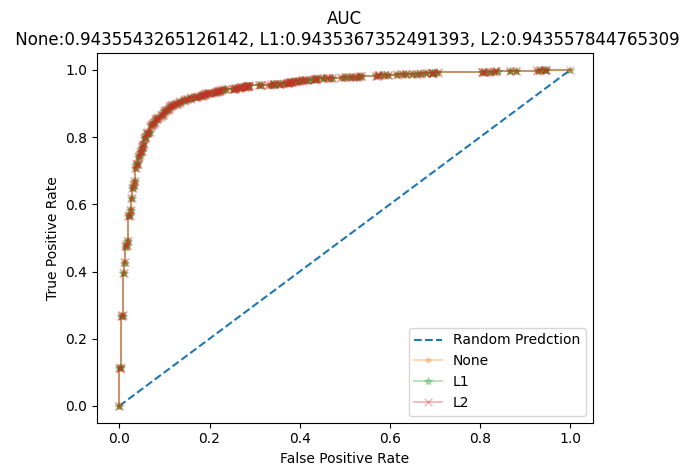

In [67]:

# Calculate the receiver operating curve and the AUC measure

lr_prob_none=lgstc_reg_none.predict_proba(X_test)
lr_prob_none=lr_prob_none[:, 1]

lr_prob_l1=lgstc_reg_l1.predict_proba(X_test)
lr_prob_l1=lr_prob_l1[:, 1]

lr_prob_l2=lgstc_reg_l2.predict_proba(X_test)
lr_prob_l2=lr_prob_l2[:, 1]

ns_prob=[0 for _ in range(len(y_test))]
ns_auc=roc_auc_score(y_test, ns_prob)
lr_auc_none=roc_auc_score(y_test,lr_prob_none)
lr_auc_l1=roc_auc_score(y_test,lr_prob_l1)
lr_auc_l2=roc_auc_score(y_test,lr_prob_l2)

print("AUC random predictions =", ns_auc)
print("AUC predictions from None =", lr_auc_none)
print("AUC predictions from L1 =", lr_auc_l1)
print("AUC predictions from L2 =", lr_auc_l2)

ns_fpr,ns_tpr,_=roc_curve(y_test,ns_prob)
lr_fpr_none,lr_tpr_none,_=roc_curve(y_test,lr_prob_none)
lr_fpr_l1,lr_tpr_l1,_=roc_curve(y_test,lr_prob_l1)
lr_fpr_l2,lr_tpr_l2,_=roc_curve(y_test,lr_prob_l2)


plt.plot(ns_fpr,ns_tpr,linestyle='--',label='Random Predction')
plt.plot(lr_fpr_none,lr_tpr_none,marker='.',alpha=0.3,label='None')
plt.plot(lr_fpr_l1,lr_tpr_l1,marker='*',alpha=0.3,label='L1')
plt.plot(lr_fpr_l2,lr_tpr_l2,marker='x',alpha=0.3,label='L2')
plt.title(f"AUC\n None:{lr_auc_none}, L1:{lr_auc_l1}, L2:{lr_auc_l2}")


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()
